This simple notebook demonstrates how users can interleave text, code, and results in a single document. We start with a simple calculation -- computing the first 25 numbers in the Fibonacci sequence, where each value equals the sum of the two previous values. The Jupyter notebook allows us to express that mathematically, using the typesetting language $\LaTeX{}$: $$F_n = F_{n-1} + F_{n-2}$$
Thus, the sequence is: 0, 1, 1, 2, 3, 5, 8, ...

The first cell contains an IPython 'magic' code, '%matplotlib', which allows the notebook to display plots inline, in the body of the notebook.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
# calculate the first 25 Fibonacci numbers
f1 = 0
f2 = 1
ar = [f1, f2] # a list to hold the computed values. We know the first two numbers

# we only need to run our calculation 23 times, because positions 1 and 2 are known
for i in range (23):
    f3 = f1 + f2
    ar.append (f3)
    f1 = f2
    f2 = f3
    
print (ar) # below, you see the output of the code itself.

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711, 28657, 46368]


Plot the data

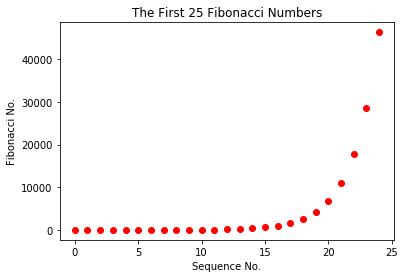

In [4]:
fig, ax = plt.subplots()
ax.plot (range(25), ar, "ro")
## uncomment the following call to ax.plot() (by removing the leading '#') and select 
## 'Cell > Run All' (in Binder) or 'Run > Run All Cells' (Jupyter) to change the graph below
# ax.plot (range(25), ar)
ax.set (xlabel = "Sequence No.", ylabel = "Fibonacci No.", 
       title = "The First 25 Fibonacci Numbers")
plt.show()

Anything you can do programmatically, can be documented in a notebook. Here we'll add an interactive map, just as in our June [mapping feature](https://www.nature.com/articles/d41586-018-05331-6) -- something you might do when working with geospatial data. This requires the Python Leaflet library, folium. (**Uncomment the following cell if you don't have folium already installed.**)

In [5]:
# !pip install folium

In [6]:
import folium

Now we create a simple map: a few points in London, Oxford and Cambridge, overlaid on either a street map, or on a map of geological data provided by the [Macrostrat Project](https://macrostrat.org/). (Click the tiles icon in the upper-right corner of the map to switch between the two layers.)

In [7]:
import pandas as pd

# create a data frame of locations
name = ["Nature", "Francis Crick Institute", "University College London", 
        "MRC Laboratory for Molecular Cell Biology", "Kings College London",
       "Imperial College London", "Cambridge University", "Oxford University",
       "Platform 9-3/4"]
lat = [51.533925,51.531877,51.524486,51.524435,51.511573,51.498780,52.206960,51.754843,51.532349]
long = [-0.121553,-0.128767,-0.133997,-0.132495,-0.116083,-0.174888,0.115034,-1.254302,-0.123806]

df = pd.DataFrame({'Name': name, 'Lat': lat, 'Long': long})

In [8]:
m = folium.Map(location = [51.8561, -0.2966], tiles = 'CartoDB positron', zoom_start = 9)

# add the locations to the map
for index,row in df.iterrows():
    folium.CircleMarker(
    location=[row['Lat'], row['Long']],
    popup=row['Name'],
    color=('crimson' if row['Name'] == 'Nature' else 'blue'),
    fill=False,
    ).add_to(m)

folium.TileLayer(tiles='https://tiles.macrostrat.org/carto/{z}/{x}/{y}.png', 
                 attr='Macrostrat', name='Macrostrat').add_to(m)
folium.LayerControl().add_to(m) # allow user to switch between layers
folium.LatLngPopup().add_to(m) # click on the map to get Lat/Long in a popup

Draw the map.

In [9]:
m

And of course, we can also do some (very!) simple sequence analysis, using the Biopython package. The following examples come from the [Biopython tutorial](http://biopython.org/DIST/docs/tutorial/Tutorial.html). First, we create a simple sequence and transcribe and translate it.

In [10]:
from Bio.Seq import Seq
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3

In [11]:
coding_dna = Seq("ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG", IUPAC.unambiguous_dna)
template_dna = coding_dna.reverse_complement()
messenger_rna = coding_dna.transcribe()
protein = messenger_rna.translate()

In [12]:
print ("Coding seq:\t5'-", coding_dna)
print ("Template seq:\t3'-", template_dna[::-1])
print ("mRNA seq:\t5'-", messenger_rna)
print ("Protein seq:\tN -", seq3(protein, custom_map={"*": "***"}))

Coding seq:	5'- ATGGCCATTGTAATGGGCCGCTGAAAGGGTGCCCGATAG
Template seq:	3'- TACCGGTAACATTACCCGGCGACTTTCCCACGGGCTATC
mRNA seq:	5'- AUGGCCAUUGUAAUGGGCCGCUGAAAGGGUGCCCGAUAG
Protein seq:	N - MetAlaIleValMetGlyArg***LysGlyAlaArg***


Next, we'll do some simple sequence sequence I/O. We'll read in a Genbank-formatted file, which represents a circular DNA, called a plasmid, from the plague bacterium, *Yersinia pestis*.

In [3]:
from Bio import SeqIO
record = SeqIO.read("NC_005816.gb", "genbank")
record.seq

Seq('TGTAACGAACGGTGCAATAGTGATCCACACCCAACGCCTGAAATCAGATCCAGG...CTG', IUPACAmbiguousDNA())

How long is the DNA, and how many sequence features are present?

In [4]:
print("Length:", len(record.seq))
print("Number of features:", len(record.features))

Length: 9609
Number of features: 41


Let's focus on one feature. The *Y. pestis pim* gene is located somewhere between positions 4300 and 4800 on the plasmid. Let's pull that sequence out specifically and see what's there.

In [10]:
sub_record = record[4300:4800]
sub_record.features

[SeqFeature(FeatureLocation(ExactPosition(42), ExactPosition(480), strand=1), type='gene'),
 SeqFeature(FeatureLocation(ExactPosition(42), ExactPosition(480), strand=1), type='CDS')]

The gene is located between positions 42 and 480, so let's translate that sequence.

In [11]:
print(sub_record.seq[42:480].translate(to_stop=True))

MGGGMISKLFCLALIFLSSSGLAEKNTYTAKDILQNLELNTFGNSLSHGIYGKQTTFKQTEFTNIKSNTKKHIALINKDNSWMISLKILGIKRDEYTVCFEDFSLIRPPTYVAIHPLLIKKVKSGNFIVVKEIKKSIPGCTVYYH


(We can double-check that by viewing the region in Genbank format.) Notice that our translation above matches the '/translation' feature shown in the Genbank record.)

In [13]:
print(sub_record.format("genbank"))

LOCUS       NC_005816                500 bp    DNA              UNK 01-JAN-1980
DEFINITION  Yersinia pestis biovar Microtus str. 91001 plasmid pPCP1, complete
            sequence.
ACCESSION   NC_005816
VERSION     NC_005816.1
KEYWORDS    .
SOURCE      .
  ORGANISM  .
            .
FEATURES             Location/Qualifiers
     gene            43..480
                     /gene="pim"
                     /locus_tag="YP_pPCP05"
                     /db_xref="GeneID:2767712"
     CDS             43..480
                     /gene="pim"
                     /locus_tag="YP_pPCP05"
                     /note="similar to many previously sequenced pesticin
                     immunity protein entries of Yersinia pestis plasmid pPCP,
                     e.g. gi| 16082683|,ref|NP_395230.1| (NC_003132) ,
                     gi|1200166|emb|CAA90861.1| (Z54145 ) , gi|1488655|
                     emb|CAA63439.1| (X92856) , gi|2996219|gb|AAC62543.1|
                     (AF053945) , and gi|576381

Document our session, for [computational reproducibility](https://www.nature.com/articles/d41586-018-05990-5)!

In [18]:
import IPython
print(IPython.sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/anaconda3/lib/python3.6/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Darwin-17.7.0-x86_64-i386-64bit',
 'sys_executable': '/anaconda3/bin/python',
 'sys_platform': 'darwin',
 'sys_version': '3.6.3 | packaged by conda-forge | (default, Oct  5 2017, '
                '19:18:17) \n'
                '[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'}


In [19]:
!pip freeze | grep -E 'folium|matplotlib|pandas|bio'

biopython==1.70
folium==0.6.0
matplotlib==2.1.0
pandas==0.20.3
